# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [11]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [12]:
# create empty dictionary
target_dfs = {}

In [13]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [14]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [15]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [16]:
frames = list(max_dfrows[target] for target in targets)

In [17]:
merged_df = pd.concat(frames, axis=0)

In [18]:
units = list(set(merged_df['Unit']))

In [19]:
units.remove('Percent')
units

['Constant USD', 'Metric Tons', 'USD']

In [20]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [21]:
merged_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.2,66.59,NaN,NaN,NaN,12
143,38,Environment (Percent),Renewable energy share in the total final ener...,7,7.2,7.2.1,Percent,Units,NaN,NaN,...,17.71,17.51,17.54,17.91,18.19,18.33,NaN,NaN,NaN,15
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
13,133,Population,Proportion of population using safely managed ...,6,6.2,6.2.1,Percent,Units,NaN,NaN,...,28.29,27.58,26.97,26.23,25.48,24.73,23.97,NaN,NaN,16
64,121,Population,Suicide mortality rate,3,3.4,3.4.2,Percent,Units,NaN,NaN,...,NaN,1.123,NaN,NaN,NaN,NaN,1.073,NaN,NaN,4


### clean-up data frames

In [22]:
# Drop unused columns, transpose
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [23]:
final_t

Target,4.2,7.2,6.1,6.2,3.4,3.9,3.6,16.a,17.2,1.1,...,15.4,2.1,9.2,9.c,15.1,15.2,9.4,14.4,8.4,8.2
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.27,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.98,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.63,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.5,NaN,NaN,NaN,NaN,NaN,45.95,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)#final_t.sample(frac=1, random_state=200).reset_index(drop=True)
final_t_shuffled

Target,4.2,7.2,6.1,6.2,3.4,3.9,3.6,16.a,17.2,1.1,...,15.4,2.1,9.2,9.c,15.1,15.2,9.4,14.4,8.4,8.2
2002,NaN,17.29,42.84,32.72,NaN,NaN,NaN,NaN,7.8409e-05,NaN,...,40.72,15,14.81,56.9,34.16,NaN,2.38841e+10,NaN,8.1,1.45
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.5,0.000143329,NaN,...,49.06,NaN,16.16,NaN,43.23,NaN,NaN,NaN,NaN,1.8
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.1,NaN,NaN,NaN,NaN,NaN,49.73,NaN,NaN
2015,NaN,NaN,54.81,23.97,1.073,0.147,NaN,35.5,0.000131555,NaN,...,49.03,10.8,16.11,95.64,43.23,NaN,NaN,NaN,NaN,1.67
2012,64.64,17.91,55.77,26.23,NaN,NaN,NaN,NaN,0.000115308,NaN,...,48.41,11.4,15.94,93.04,42.7,NaN,3.15929e+10,NaN,NaN,1.9
2008,58.89,17.14,52.49,28.98,NaN,NaN,NaN,NaN,0.000112242,NaN,...,45.95,13,15.74,84.22,41.28,NaN,2.91648e+10,52.83,9.78,1.83
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.98,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,58.66,16.97,49.46,30.32,NaN,NaN,NaN,NaN,0.000109094,NaN,...,44.14,14.3,15.61,79.49,39.42,NaN,2.78903e+10,51.51,9.42,3.85


### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the mean average error (MAE) is lower than 1%.

In [25]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [26]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


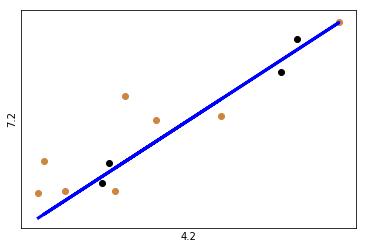

4.2 7.2
MAE: 0.22765
RMSE: 0.28641
R2: 0.632
Coefficient 0.16371969157402538
--------------------------


4.2 6.1
MAE: 2.59359
RMSE: 2.94380
R2: 0.547
Coefficient 0.7371296460401463
--------------------------




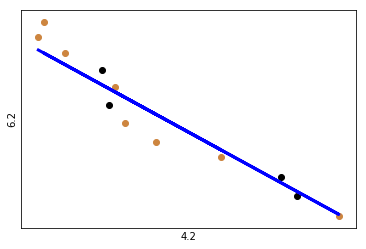

4.2 6.2
MAE: 0.58587
RMSE: 0.70976
R2: 0.912
Coefficient -0.6241883657020719
--------------------------


17.2 4.2
MAE: 5.42372
RMSE: 6.74858
R2: 0.000
Coefficient 571895.9895128921
--------------------------


17.2 7.1
MAE: 16.47934
RMSE: 23.18175
R2: nan
Coefficient 803735.8103044721
--------------------------


17.2 12.2
MAE: 0.26627
RMSE: 0.37448
R2: 0.728
Coefficient 43672.0940193962
--------------------------


17.2 9.5
MAE: 3.05154
RMSE: 4.36001
R2: 0.789
Coefficient 561007.4014136026
--------------------------


17.2 14.5
MAE: 5.86297
RMSE: 6.10661
R2: 0.000
Coefficient 69648.58889410776
--------------------------


17.2 17.8
MAE: 4.30063
RMSE: 5.69807
R2: 0.705
Coefficient 634202.0360383239
--------------------------


17.2 17.3
MAE: 0.03082
RMSE: 0.04471
R2: 0.833
Coefficient 5830.007515656349
--------------------------


17.2 3.1
MAE: 8.11197
RMSE: 10.25469
R2: nan
Coefficient -442895.6765385244
--------------------------


17.2 3.3
MAE: 0.47122
RMSE: 0.62980
R2: 0.544
Coeff

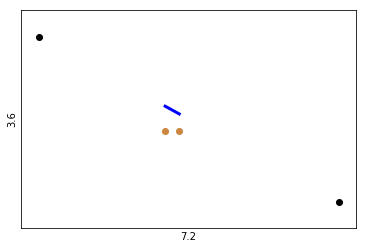

7.2 3.6
MAE: 0.01766
RMSE: 0.01796
R2: nan
Coefficient -0.10937499999999997
--------------------------


17.2 7.2
MAE: 0.33265
RMSE: 0.39545
R2: 0.130
Coefficient 14635.427761271036
--------------------------


17.2 15.4
MAE: 1.00345
RMSE: 1.35397
R2: 0.846
Coefficient 139103.46637851716
--------------------------


17.2 2.1
MAE: 0.60352
RMSE: 0.92158
R2: 0.623
Coefficient -85140.94990713692
--------------------------


17.2 9.2
MAE: 0.23356
RMSE: 0.31819
R2: 0.453
Coefficient 21513.421101724787
--------------------------


17.2 9.c
MAE: 7.54621
RMSE: 11.74624
R2: 0.335
Coefficient 796989.7565420856
--------------------------


17.2 15.1
MAE: 1.34203
RMSE: 1.47086
R2: 0.857
Coefficient 146225.8859456459
--------------------------


9.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.833
Coefficient 4.84725936945202e-15
--------------------------


6.1 6.2
MAE: 1.06710
RMSE: 1.20412
R2: 0.816
Coefficient -0.6096452475836777
--------------------------




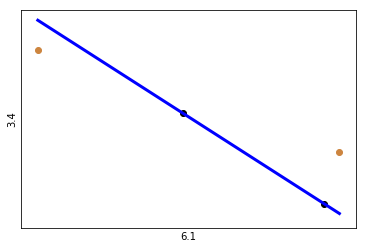

6.1 3.4
MAE: 0.04442
RMSE: 0.04692
R2: nan
Coefficient -0.012865497076023398
--------------------------




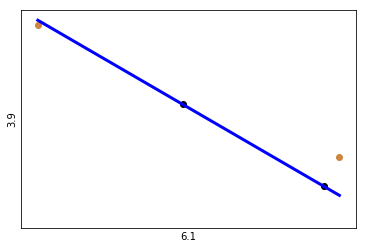

6.1 3.9
MAE: 0.00942
RMSE: 0.01203
R2: nan
Coefficient -0.005263157894736839
--------------------------




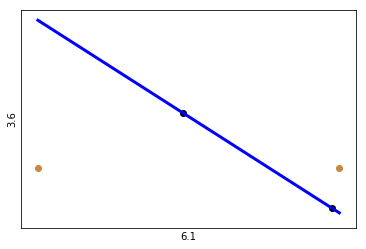

6.1 3.6
MAE: 0.14097
RMSE: 0.15948
R2: nan
Coefficient -0.019310344827586225
--------------------------


6.1 16.a
MAE: 3.66111
RMSE: 3.66890
R2: nan
Coefficient 1.1111111111111107
--------------------------


17.2 6.1
MAE: 1.32429
RMSE: 1.90630
R2: 0.884
Coefficient 254451.68837087194
--------------------------


17.2 14.4
MAE: 9.06990
RMSE: 10.52510
R2: 0.000
Coefficient 525436.9091789469
--------------------------


17.2 8.4
MAE: 0.26627
RMSE: 0.37448
R2: 0.728
Coefficient 43672.0940193962
--------------------------


17.2 8.2
MAE: 1.05427
RMSE: 1.32676
R2: 0.000
Coefficient -604.8858705454962
--------------------------




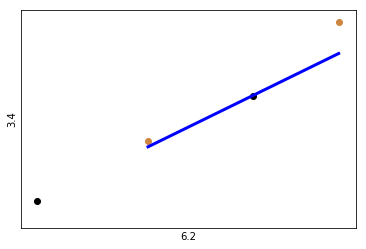

6.2 3.4
MAE: 0.01527
RMSE: 0.01862
R2: nan
Coefficient 0.012571428571428584
--------------------------




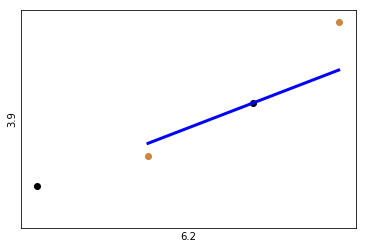

6.2 3.9
MAE: 0.01311
RMSE: 0.01512
R2: nan
Coefficient 0.0051428571428571435
--------------------------




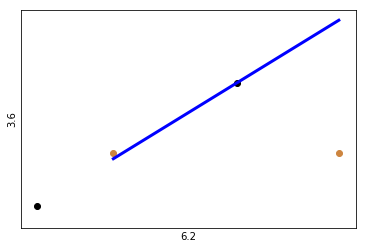

6.2 3.6
MAE: 0.07880
RMSE: 0.10697
R2: nan
Coefficient 0.02550091074681242
--------------------------


6.2 16.a
MAE: 4.99514
RMSE: 6.20180
R2: nan
Coefficient -1.085714285714286
--------------------------


17.2 6.2
MAE: 1.06924
RMSE: 1.41955
R2: 0.744
Coefficient -169049.2253875239
--------------------------




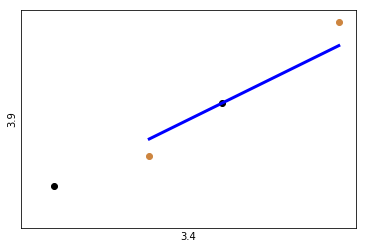

3.4 3.9
MAE: 0.00875
RMSE: 0.00885
R2: nan
Coefficient 0.40909090909090867
--------------------------


3.4 16.a
MAE: 4.07500
RMSE: 4.70746
R2: nan
Coefficient -86.36363636363629
--------------------------


17.2 3.4
MAE: 0.09437
RMSE: 0.12716
R2: nan
Coefficient -5413.1693799153045
--------------------------


3.9 16.a
MAE: 2.22778
RMSE: 3.05013
R2: nan
Coefficient -211.11111111111111
--------------------------


17.2 3.9
MAE: 0.03731
RMSE: 0.04554
R2: nan
Coefficient -2214.4783826926223
--------------------------


17.2 3.6
MAE: 0.53283
RMSE: 0.72979
R2: nan
Coefficient -21407.97171701109
--------------------------


17.2 16.a
MAE: 7.34509
RMSE: 8.97269
R2: 0.000
Coefficient 84937.30352939968
--------------------------


12.2 9.5
MAE: 1.72828
RMSE: 2.04544
R2: 0.922
Coefficient 8.490554517133955
--------------------------


12.2 17.8
MAE: 2.10170
RMSE: 2.72705
R2: 0.859
Coefficient 7.3968224299065435
--------------------------




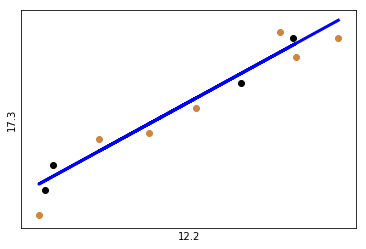

12.2 17.3
MAE: 0.02570
RMSE: 0.02814
R2: 0.915
Coefficient 0.1233021806853583
--------------------------




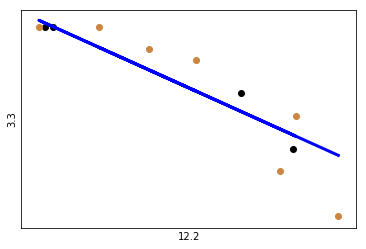

12.2 3.3
MAE: 0.25943
RMSE: 0.29880
R2: 0.769
Coefficient -0.5775700934579425
--------------------------


12.2 8.1
MAE: 1.82093
RMSE: 2.19188
R2: 0.000
Coefficient 0.2876012461059194
--------------------------


17.19 12.2
MAE: 0.19643
RMSE: 0.22891
R2: 0.000
Coefficient 4.218661419645584e-09
--------------------------


17.19 14.4
MAE: 4.45791
RMSE: 4.75958
R2: 0.000
Coefficient 1.546842520536717e-08
--------------------------


17.19 8.4
MAE: 0.19643
RMSE: 0.22891
R2: 0.000
Coefficient 4.218661419645584e-09
--------------------------


17.19 8.2
MAE: 4.59924
RMSE: 4.80323
R2: 0.000
Coefficient -2.419322153991645e-08
--------------------------




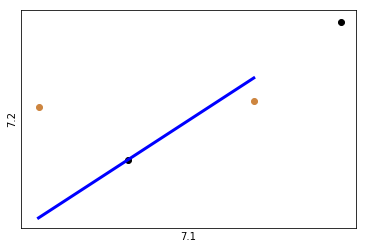

7.1 7.2
MAE: 0.69022
RMSE: 0.82421
R2: nan
Coefficient 0.20431654676258965
--------------------------


7.1 6.1
MAE: 3.71921
RMSE: 3.73246
R2: nan
Coefficient 1.0158273381294967
--------------------------




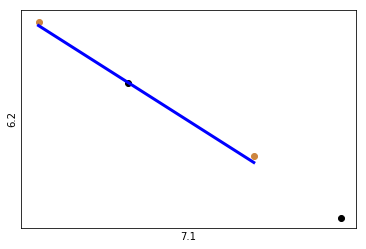

7.1 6.2
MAE: 0.22524
RMSE: 0.23736
R2: nan
Coefficient -0.8978417266187045
--------------------------




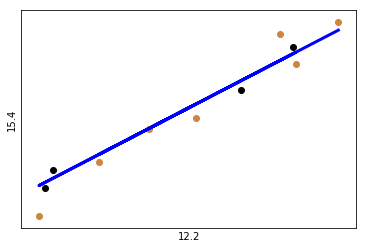

12.2 15.4
MAE: 0.59433
RMSE: 0.72947
R2: 0.931
Coefficient 3.138193146417447
--------------------------




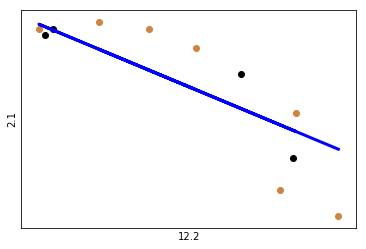

12.2 2.1
MAE: 0.58667
RMSE: 0.67395
R2: 0.670
Coefficient -0.9221183800623053
--------------------------




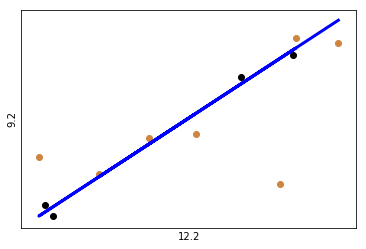

12.2 9.2
MAE: 0.20548
RMSE: 0.31303
R2: 0.052
Coefficient 0.5396261682242991
--------------------------


12.2 9.c
MAE: 7.58750
RMSE: 10.21922
R2: 0.264
Coefficient 16.44735202492212
--------------------------




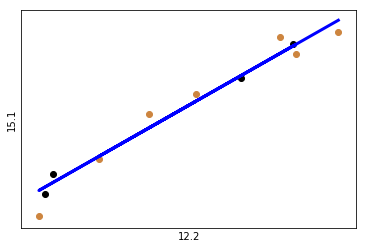

12.2 15.1
MAE: 0.68818
RMSE: 0.77889
R2: 0.949
Coefficient 4.436137071651092
--------------------------


9.4 12.2
MAE: 0.05996
RMSE: 0.06602
R2: 0.992
Coefficient 3.1415615539913317e-10
--------------------------




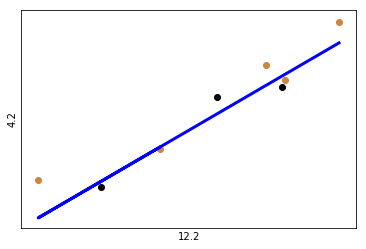

12.2 4.2
MAE: 0.41259
RMSE: 0.51328
R2: 0.858
Coefficient 2.470487215367005
--------------------------




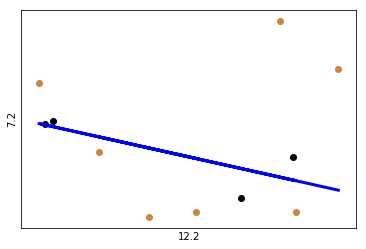

12.2 7.2
MAE: 0.29162
RMSE: 0.35259
R2: 0.000
Coefficient -0.13333333333333353
--------------------------




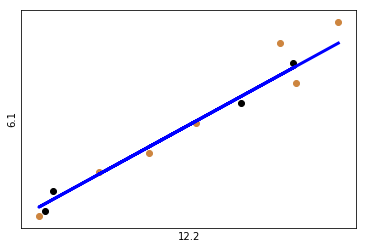

12.2 6.1
MAE: 0.94574
RMSE: 1.23218
R2: 0.937
Coefficient 5.901682242990654
--------------------------




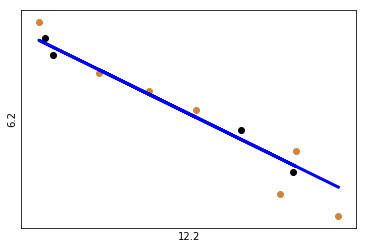

12.2 6.2
MAE: 0.50819
RMSE: 0.62736
R2: 0.904
Coefficient -2.232834890965733
--------------------------


12.2 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
Coefficient 3.666666666666673
--------------------------




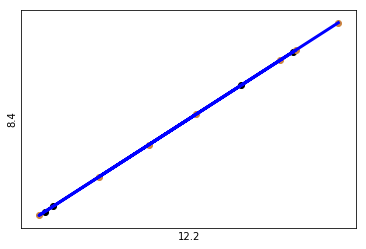

12.2 8.4
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
Coefficient 1.0000000000000002
--------------------------


12.2 8.2
MAE: 1.32384
RMSE: 1.65040
R2: 0.000
Coefficient 0.9172585669781937
--------------------------


9.5 4.2
MAE: 1.13402
RMSE: 1.30310
R2: 0.833
Coefficient 0.4642092614228206
--------------------------




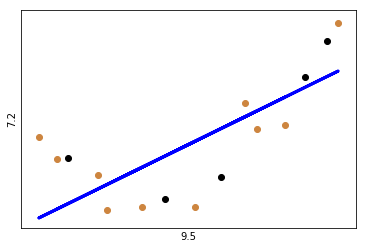

9.5 7.2
MAE: 0.29622
RMSE: 0.33972
R2: 0.358
Coefficient 0.03876326137194816
--------------------------


9.5 6.1
MAE: 1.35809
RMSE: 1.52568
R2: 0.926
Coefficient 0.49955845503585816
--------------------------




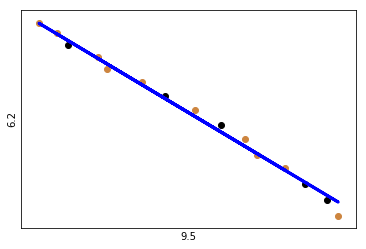

9.5 6.2
MAE: 0.19426
RMSE: 0.26228
R2: 0.991
Coefficient -0.28663327356474827
--------------------------




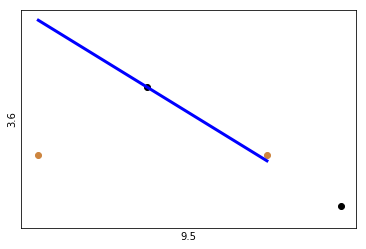

9.5 3.6
MAE: 0.08259
RMSE: 0.11216
R2: nan
Coefficient -0.007770439029805192
--------------------------




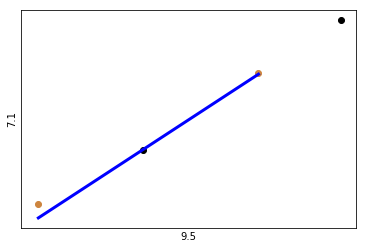

9.5 7.1
MAE: 0.39252
RMSE: 0.52089
R2: nan
Coefficient 0.36385529553426565
--------------------------


9.5 17.8
MAE: 1.05994
RMSE: 1.39741
R2: 0.982
Coefficient 1.0784372735633556
--------------------------




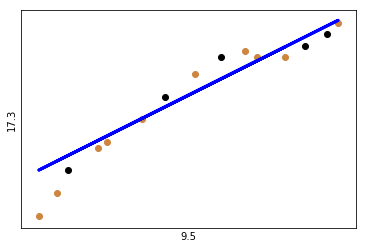

9.5 17.3
MAE: 0.02516
RMSE: 0.03483
R2: 0.899
Coefficient 0.009057213113215827
--------------------------




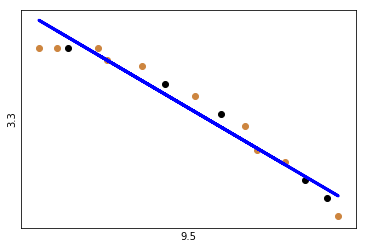

9.5 3.3
MAE: 0.20378
RMSE: 0.24968
R2: 0.928
Coefficient -0.10072705895926859
--------------------------


9.5 8.1
MAE: 1.34389
RMSE: 1.75648
R2: 0.004
Coefficient -0.014725543642856444
--------------------------




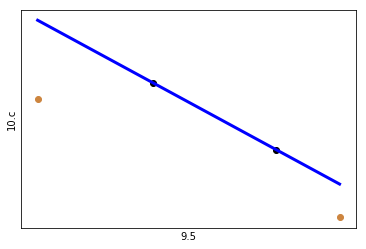

9.5 10.c
MAE: 0.33347
RMSE: 0.36098
R2: nan
Coefficient -0.18885741265344722
--------------------------


17.19 9.5
MAE: 7.30274
RMSE: 8.31660
R2: 0.000
Coefficient 7.007834909584254e-08
--------------------------


14.5 6.1
MAE: 5.13362
RMSE: 5.23014
R2: nan
Coefficient 0.7574750830564787
--------------------------


14.5 6.2
MAE: 1.01008
RMSE: 1.33502
R2: nan
Coefficient -0.7751937984496124
--------------------------




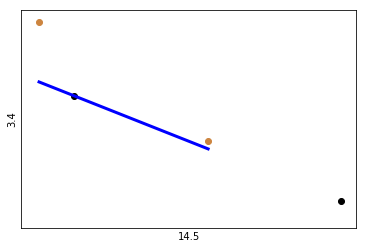

14.5 3.4
MAE: 0.02797
RMSE: 0.03536
R2: nan
Coefficient -0.009745293466223706
--------------------------




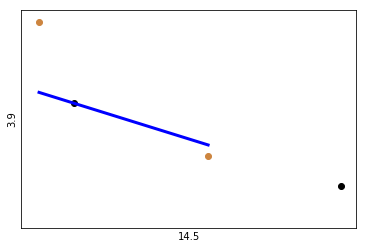

14.5 3.9
MAE: 0.01760
RMSE: 0.02172
R2: nan
Coefficient -0.003986710963455149
--------------------------


14.5 16.a
MAE: 4.37886
RMSE: 4.72282
R2: 0.545
Coefficient 1.2195121951219503
--------------------------


14.5 17.8
MAE: 3.16344
RMSE: 3.97683
R2: nan
Coefficient 3.099667774086378
--------------------------




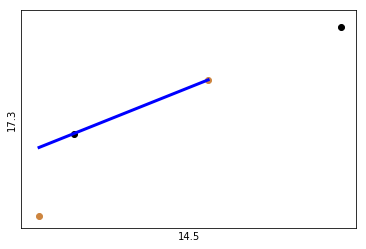

14.5 17.3
MAE: 0.07117
RMSE: 0.10005
R2: nan
Coefficient 0.024363233665559245
--------------------------


14.5 3.1
MAE: 2.46960
RMSE: 3.11440
R2: nan
Coefficient -0.7973421926910296
--------------------------




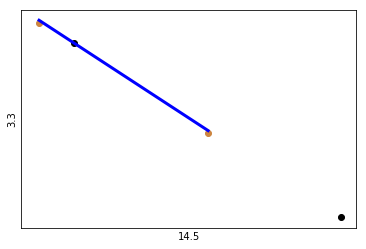

14.5 3.3
MAE: 0.04468
RMSE: 0.04498
R2: nan
Coefficient -0.2990033222591361
--------------------------




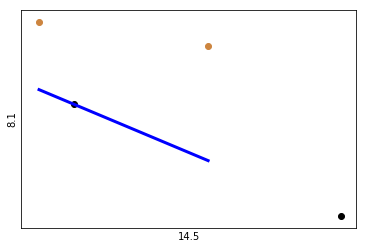

14.5 8.1
MAE: 0.73344
RMSE: 0.75766
R2: nan
Coefficient -0.09966777408637874
--------------------------




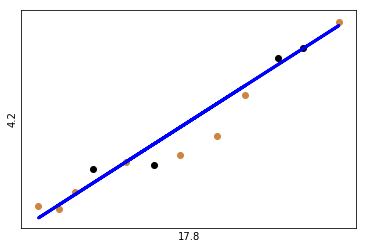

17.8 4.2
MAE: 0.62906
RMSE: 0.88066
R2: 0.924
Coefficient 0.3687249353422961
--------------------------




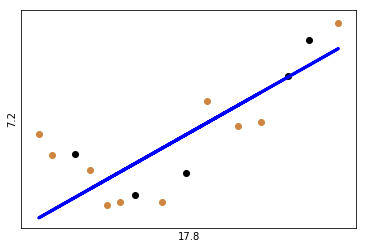

17.8 7.2
MAE: 0.28881
RMSE: 0.32955
R2: 0.396
Coefficient 0.03950096921952729
--------------------------


17.8 6.1
MAE: 2.29816
RMSE: 2.52561
R2: 0.797
Coefficient 0.34744662839700846
--------------------------




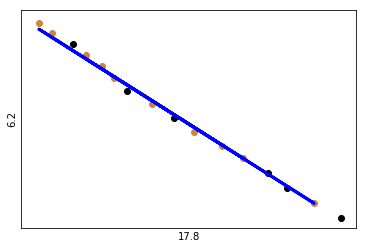

17.8 6.2
MAE: 0.14681
RMSE: 0.17409
R2: 0.996
Coefficient -0.2580667747577949
--------------------------




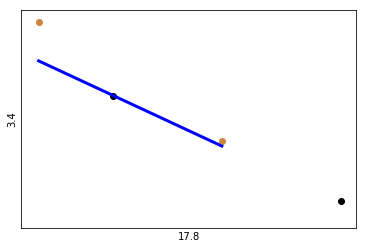

17.8 3.4
MAE: 0.01802
RMSE: 0.02285
R2: nan
Coefficient -0.0031439799928545935
--------------------------




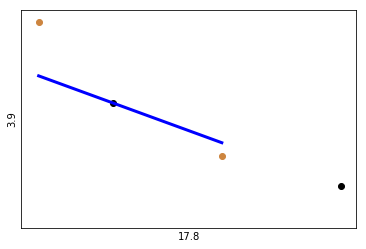

17.8 3.9
MAE: 0.01450
RMSE: 0.01689
R2: nan
Coefficient -0.0012861736334405145
--------------------------




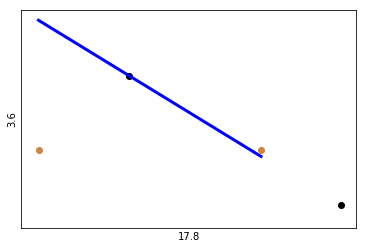

17.8 3.6
MAE: 0.07369
RMSE: 0.09922
R2: nan
Coefficient -0.006535947712418308
--------------------------


17.8 16.a
MAE: 5.28855
RMSE: 6.57903
R2: nan
Coefficient 0.27152554483744196
--------------------------




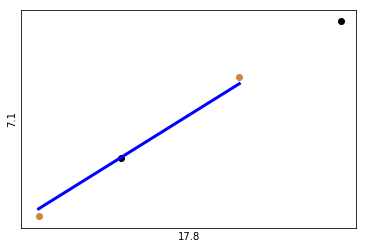

17.8 7.1
MAE: 0.35633
RMSE: 0.35633
R2: nan
Coefficient 0.2810351799433888
--------------------------




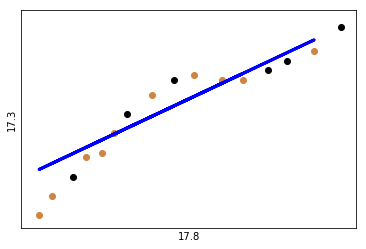

17.8 17.3
MAE: 0.03435
RMSE: 0.04400
R2: 0.838
Coefficient 0.007904584679647187
--------------------------


17.8 3.1
MAE: 1.84968
RMSE: 2.14379
R2: nan
Coefficient -0.2572347266881029
--------------------------




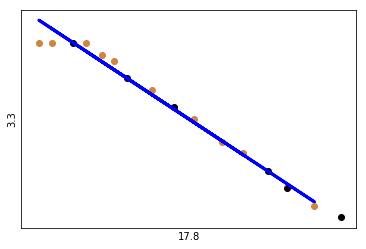

17.8 3.3
MAE: 0.13161
RMSE: 0.17243
R2: 0.966
Coefficient -0.09236806055819015
--------------------------


17.8 8.1
MAE: 1.32215
RMSE: 1.77198
R2: 0.000
Coefficient -0.005271926993890775
--------------------------




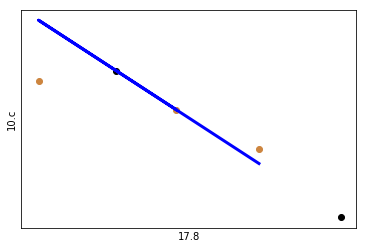

17.8 10.c
MAE: 0.25866
RMSE: 0.36947
R2: 0.000
Coefficient -0.1675977653631284
--------------------------


17.19 17.8
MAE: 7.89030
RMSE: 8.58829
R2: 0.000
Coefficient 7.566600282613928e-08
--------------------------


17.3 4.2
MAE: 2.17038
RMSE: 2.50841
R2: 0.382
Coefficient 60.0836363636364
--------------------------




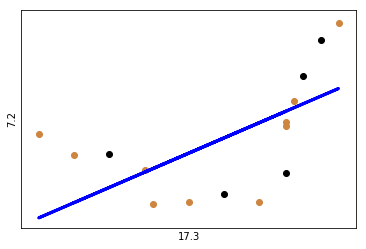

17.3 7.2
MAE: 0.31355
RMSE: 0.38817
R2: 0.162
Coefficient 3.0173319327731165
--------------------------


17.3 6.1
MAE: 1.10563
RMSE: 1.58229
R2: 0.920
Coefficient 43.59767441860465
--------------------------




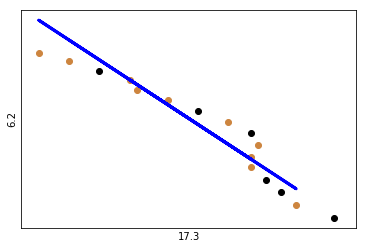

17.3 6.2
MAE: 0.78321
RMSE: 0.98848
R2: 0.876
Coefficient -29.492441860465117
--------------------------




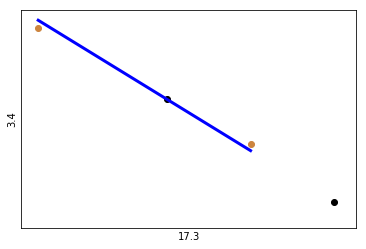

17.3 3.4
MAE: 0.00650
RMSE: 0.00652
R2: nan
Coefficient -0.40000000000000036
--------------------------




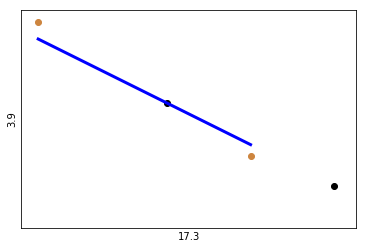

17.3 3.9
MAE: 0.00609
RMSE: 0.00619
R2: nan
Coefficient -0.16363636363636364
--------------------------




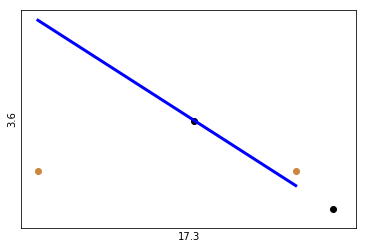

17.3 3.6
MAE: 0.13067
RMSE: 0.16952
R2: nan
Coefficient -0.9333333333333348
--------------------------


17.3 16.a
MAE: 3.51364
RMSE: 4.20696
R2: nan
Coefficient 34.545454545454554
--------------------------


17.3 7.1
MAE: 2.19853
RMSE: 2.84868
R2: nan
Coefficient 40.88235294117649
--------------------------




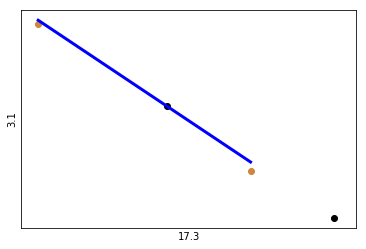

17.3 3.1
MAE: 0.43182
RMSE: 0.46341
R2: nan
Coefficient -32.72727272727273
--------------------------




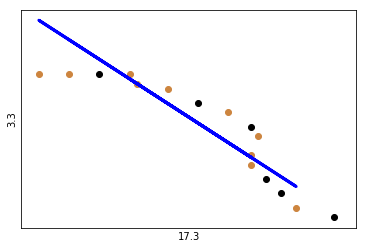

17.3 3.3
MAE: 0.40856
RMSE: 0.53294
R2: 0.674
Coefficient -10.267441860465116
--------------------------


17.3 8.1
MAE: 1.32604
RMSE: 1.77380
R2: 0.000
Coefficient -0.3517441860465126
--------------------------




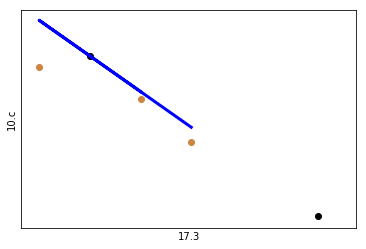

17.3 10.c
MAE: 0.21111
RMSE: 0.26458
R2: 0.149
Coefficient -16.666666666666668
--------------------------


17.19 17.3
MAE: 0.11237
RMSE: 0.12583
R2: 0.000
Coefficient 8.519625592484218e-10
--------------------------


3.1 6.1
MAE: 2.78750
RMSE: 2.90072
R2: nan
Coefficient -0.9500000000000006
--------------------------


3.1 6.2
MAE: 1.52806
RMSE: 1.74118
R2: nan
Coefficient 0.9722222222222224
--------------------------




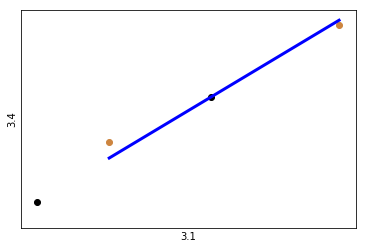

3.1 3.4
MAE: 0.00856
RMSE: 0.00980
R2: nan
Coefficient 0.012222222222222235
--------------------------




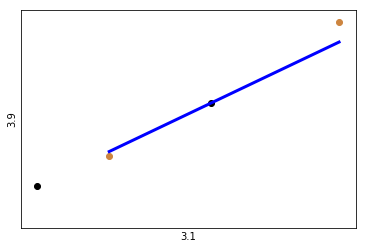

3.1 3.9
MAE: 0.00525
RMSE: 0.00617
R2: nan
Coefficient 0.005000000000000002
--------------------------


3.1 16.a
MAE: 3.33611
RMSE: 4.33583
R2: nan
Coefficient -1.055555555555556
--------------------------




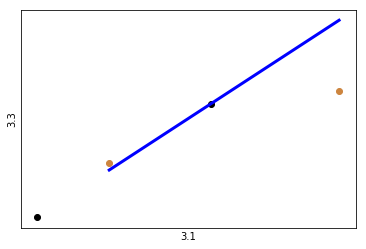

3.1 3.3
MAE: 0.93125
RMSE: 1.19964
R2: nan
Coefficient 0.37500000000000006
--------------------------




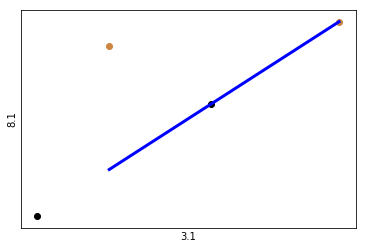

3.1 8.1
MAE: 0.49875
RMSE: 0.70357
R2: nan
Coefficient 0.12500000000000003
--------------------------




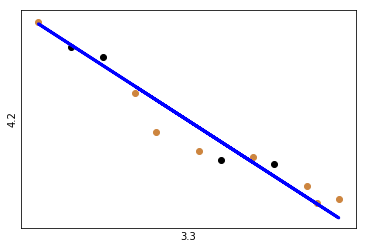

3.3 4.2
MAE: 0.69555
RMSE: 0.90304
R2: 0.920
Coefficient -3.8673553719008233
--------------------------




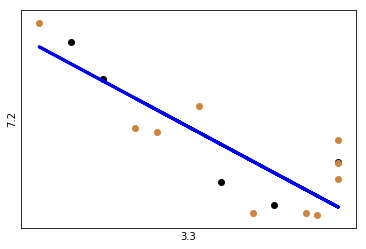

3.3 7.2
MAE: 0.25125
RMSE: 0.27385
R2: 0.583
Coefficient -0.4281557743957035
--------------------------


3.3 6.1
MAE: 2.59709
RMSE: 2.93162
R2: 0.727
Coefficient -3.7497115384615367
--------------------------




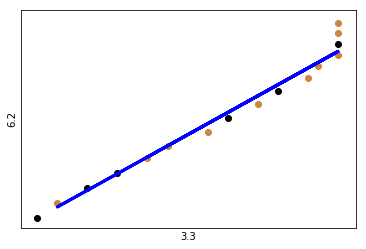

3.3 6.2
MAE: 0.43620
RMSE: 0.60802
R2: 0.953
Coefficient 2.79
--------------------------




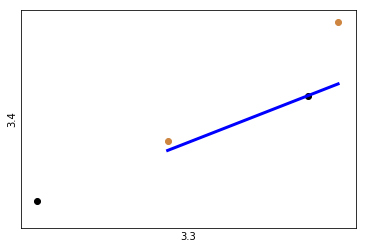

3.3 3.4
MAE: 0.02943
RMSE: 0.03662
R2: nan
Coefficient 0.03259259259259264
--------------------------




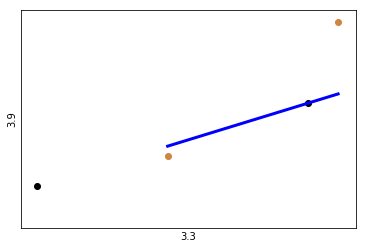

3.3 3.9
MAE: 0.01767
RMSE: 0.02213
R2: nan
Coefficient 0.01333333333333334
--------------------------




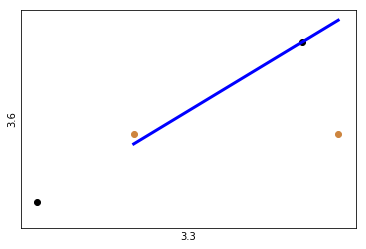

3.3 3.6
MAE: 0.05409
RMSE: 0.07036
R2: nan
Coefficient 0.06363636363636371
--------------------------


3.3 16.a
MAE: 5.95741
RMSE: 7.71249
R2: nan
Coefficient -2.8148148148148167
--------------------------


3.3 7.1
MAE: 1.16200
RMSE: 1.49712
R2: nan
Coefficient -2.780000000000004
--------------------------


3.3 8.1
MAE: 1.32102
RMSE: 1.77315
R2: 0.000
Coefficient 0.05658653846153856
--------------------------




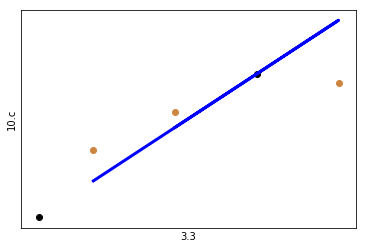

3.3 10.c
MAE: 0.38333
RMSE: 0.43625
R2: 0.000
Coefficient 1.8749999999999984
--------------------------


17.19 3.3
MAE: 0.69219
RMSE: 0.75960
R2: 0.000
Coefficient -6.6652020540680895e-09
--------------------------


8.1 4.2
MAE: 3.29238
RMSE: 3.85719
R2: 0.000
Coefficient -0.8517221666428488
--------------------------




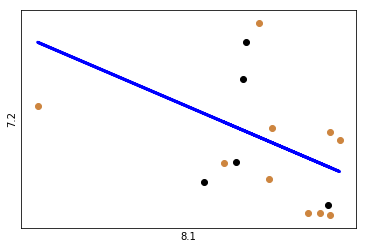

8.1 7.2
MAE: 0.36626
RMSE: 0.41235
R2: 0.054
Coefficient -0.1546675776643934
--------------------------


8.1 6.1
MAE: 4.92029
RMSE: 5.99257
R2: 0.000
Coefficient -0.4672805562960599
--------------------------


8.1 6.2
MAE: 2.87897
RMSE: 3.33481
R2: 0.000
Coefficient 0.18903764215777116
--------------------------




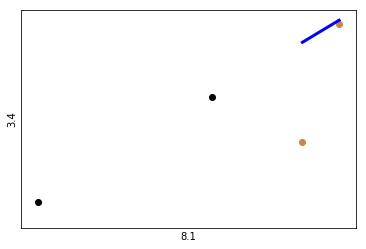

8.1 3.4
MAE: 0.04374
RMSE: 0.05942
R2: nan
Coefficient 0.09777777777777785
--------------------------




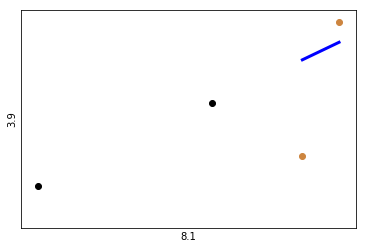

8.1 3.9
MAE: 0.02520
RMSE: 0.03018
R2: nan
Coefficient 0.04
--------------------------




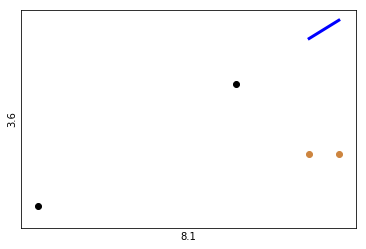

8.1 3.6
MAE: 0.14228
RMSE: 0.14267
R2: nan
Coefficient 0.11023622047244104
--------------------------


8.1 16.a
MAE: 7.54778
RMSE: 7.68040
R2: nan
Coefficient -8.444444444444446
--------------------------


8.1 7.1
MAE: 4.51175
RMSE: 5.34441
R2: nan
Coefficient -6.950000000000001
--------------------------




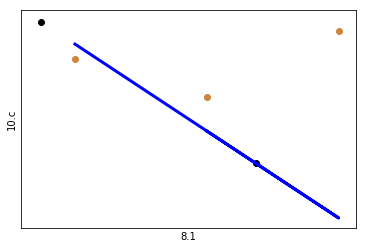

8.1 10.c
MAE: 0.83333
RMSE: 1.16527
R2: 0.000
Coefficient -3.4090909090909096
--------------------------


17.19 8.1
MAE: 5.98952
RMSE: 6.22818
R2: 0.000
Coefficient -3.034380073800204e-08
--------------------------


10.c 4.2
MAE: 1.48500
RMSE: 1.62304
R2: nan
Coefficient -1.4000000000000052
--------------------------




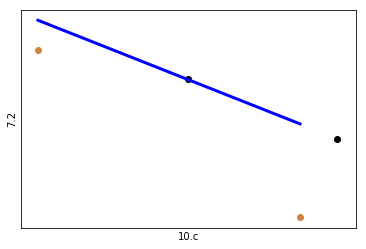

10.c 7.2
MAE: 0.29000
RMSE: 0.32650
R2: nan
Coefficient -0.7000000000000026
--------------------------




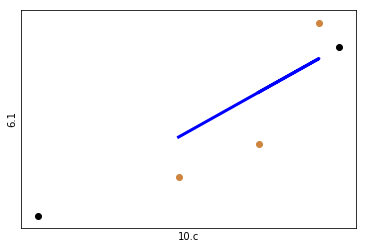

10.c 6.1
MAE: 0.24200
RMSE: 0.24497
R2: 0.580
Coefficient 0.6400000000000005
--------------------------




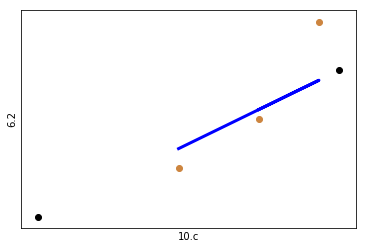

10.c 6.2
MAE: 0.44422
RMSE: 0.54828
R2: 0.653
Coefficient 1.506666666666667
--------------------------


17.19 10.c
MAE: 0.46362
RMSE: 0.47335
R2: nan
Coefficient -1.7057176814010022e-09
--------------------------


17.19 4.2
MAE: 2.05952
RMSE: 2.59311
R2: 0.179
Coefficient 6.242359208422907e-09
--------------------------


17.19 7.2
MAE: 0.45338
RMSE: 0.48355
R2: 0.000
Coefficient 2.506031597003766e-09
--------------------------


17.19 6.1
MAE: 4.61064
RMSE: 4.91415
R2: 0.000
Coefficient 3.834017552156843e-08
--------------------------


17.19 6.2
MAE: 1.87301
RMSE: 2.03220
R2: 0.000
Coefficient -1.774281005559217e-08
--------------------------


15.4 4.2
MAE: 1.54121
RMSE: 1.83046
R2: 0.671
Coefficient 1.538715697794983
--------------------------




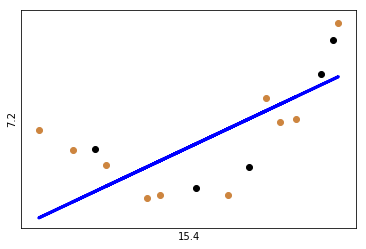

15.4 7.2
MAE: 0.32901
RMSE: 0.38030
R2: 0.196
Coefficient 0.11383250459931611
--------------------------


15.4 6.1
MAE: 1.09218
RMSE: 1.35548
R2: 0.942
Coefficient 1.4789230510882112
--------------------------




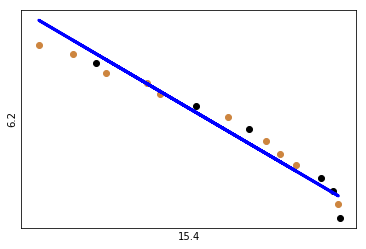

15.4 6.2
MAE: 0.58198
RMSE: 0.69184
R2: 0.939
Coefficient -0.9764141656126321
--------------------------




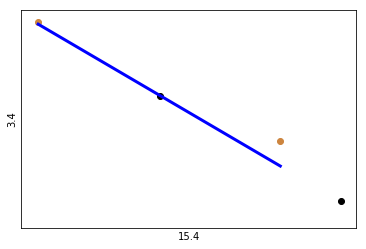

15.4 3.4
MAE: 0.01107
RMSE: 0.01462
R2: nan
Coefficient -0.01440261865793782
--------------------------




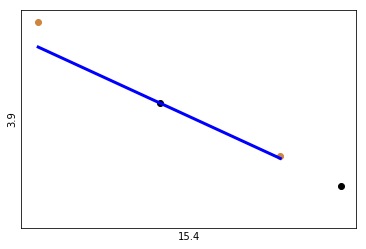

15.4 3.9
MAE: 0.00582
RMSE: 0.00757
R2: nan
Coefficient -0.005891980360065466
--------------------------




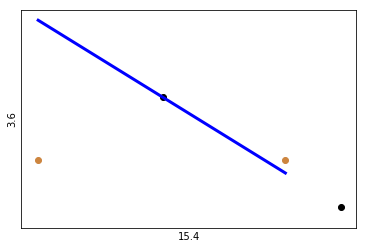

15.4 3.6
MAE: 0.09729
RMSE: 0.12641
R2: nan
Coefficient -0.023728813559322062
--------------------------


15.4 16.a
MAE: 194.50000
RMSE: 220.92590
R2: 0.000
Coefficient 33.33333333333206
--------------------------


15.4 7.1
MAE: 1.16940
RMSE: 1.32329
R2: nan
Coefficient 1.1449752883031306
--------------------------


15.4 9.5
MAE: 1.35177
RMSE: 1.69466
R2: 0.968
Coefficient 3.0988217269968814
--------------------------


15.4 14.5
MAE: 159.65000
RMSE: 182.86676
R2: 0.000
Coefficient 27.3333333333323
--------------------------


15.4 17.8
MAE: 2.58616
RMSE: 3.13535
R2: 0.911
Coefficient 3.721477815967821
--------------------------




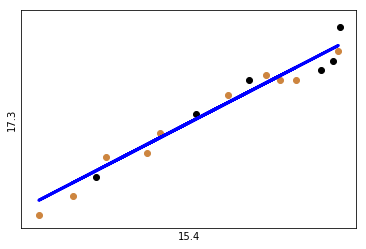

15.4 17.3
MAE: 0.01806
RMSE: 0.01956
R2: 0.968
Coefficient 0.031397657962726463
--------------------------




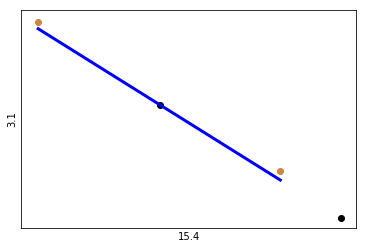

15.4 3.1
MAE: 0.51465
RMSE: 0.52105
R2: nan
Coefficient -1.178396072013093
--------------------------




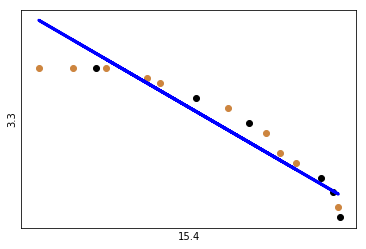

15.4 3.3
MAE: 0.33440
RMSE: 0.42363
R2: 0.794
Coefficient -0.3437658394097612
--------------------------


15.4 8.1
MAE: 1.31788
RMSE: 1.76560
R2: 0.000
Coefficient -0.021151668559050877
--------------------------


15.4 10.c
MAE: 1.12527
RMSE: 1.35024
R2: 0.000
Coefficient -2.4193548387096597
--------------------------




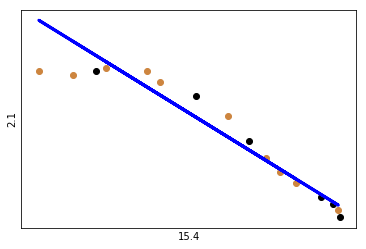

15.4 2.1
MAE: 0.44288
RMSE: 0.61988
R2: 0.829
Coefficient -0.5207112077930283
--------------------------




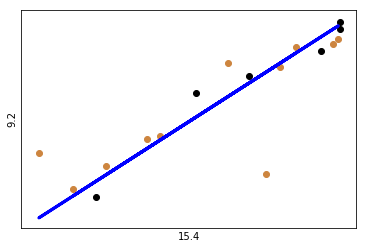

15.4 9.2
MAE: 0.18763
RMSE: 0.29656
R2: 0.525
Coefficient 0.14539266188889807
--------------------------


15.4 9.c
MAE: 5.10963
RMSE: 9.25937
R2: 0.587
Coefficient 4.453894588294746
--------------------------




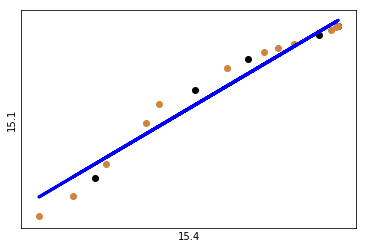

15.4 15.1
MAE: 0.67028
RMSE: 0.76953
R2: 0.961
Coefficient 1.0314565676771177
--------------------------


9.4 15.4
MAE: 0.50560
RMSE: 0.60789
R2: 0.966
Coefficient 1.001923601273536e-09
--------------------------


2.1 4.2
MAE: 1.09782
RMSE: 1.35229
R2: 0.820
Coefficient -2.292954990215265
--------------------------




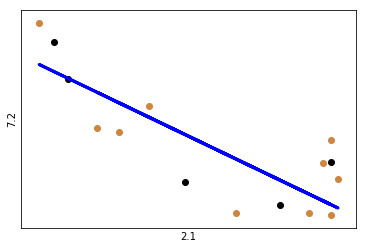

2.1 7.2
MAE: 0.24841
RMSE: 0.27708
R2: 0.573
Coefficient -0.26175139275766074
--------------------------


2.1 6.1
MAE: 2.13427
RMSE: 2.53772
R2: 0.795
Coefficient -2.600442334663932
--------------------------




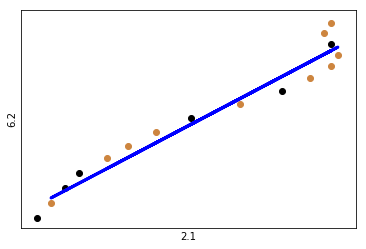

2.1 6.2
MAE: 0.66991
RMSE: 0.75464
R2: 0.928
Coefficient 1.8497141007659932
--------------------------




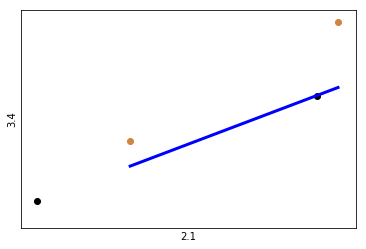

2.1 3.4
MAE: 0.03745
RMSE: 0.04104
R2: nan
Coefficient 0.022564102564102594
--------------------------




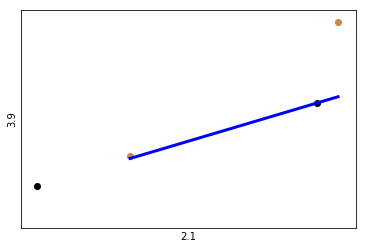

2.1 3.9
MAE: 0.01662
RMSE: 0.02280
R2: nan
Coefficient 0.009230769230769235
--------------------------




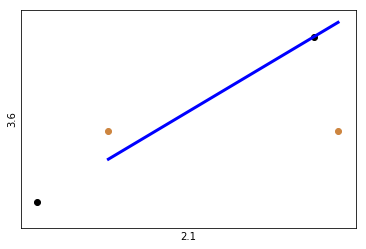

2.1 3.6
MAE: 0.05800
RMSE: 0.06723
R2: nan
Coefficient 0.040000000000000036
--------------------------


2.1 16.a
MAE: 5.59103
RMSE: 7.85991
R2: nan
Coefficient -1.94871794871795
--------------------------


2.1 7.1
MAE: 1.57514
RMSE: 1.76726
R2: nan
Coefficient -1.8783783783783794
--------------------------


2.1 9.5
MAE: 1.89939
RMSE: 2.52024
R2: 0.930
Coefficient -5.99238161559889
--------------------------




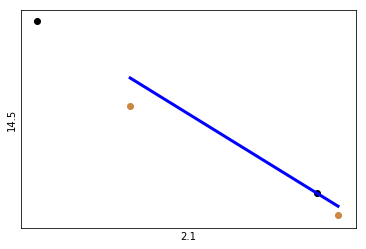

2.1 14.5
MAE: 0.97269
RMSE: 1.09245
R2: nan
Coefficient -2.3153846153846165
--------------------------


2.1 17.8
MAE: 2.52283
RMSE: 2.74324
R2: 0.932
Coefficient -7.165087927500267
--------------------------




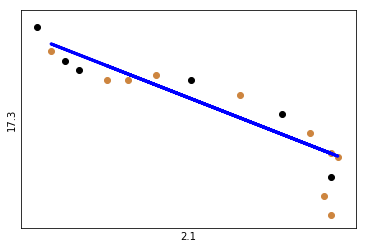

2.1 17.3
MAE: 0.03765
RMSE: 0.05466
R2: 0.751
Coefficient -0.0566619915848527
--------------------------


2.1 3.1
MAE: 2.67308
RMSE: 3.38275
R2: nan
Coefficient 1.846153846153847
--------------------------




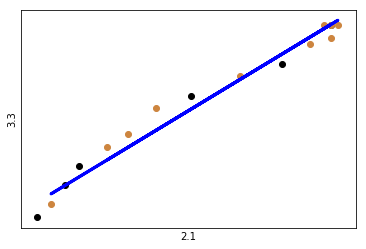

2.1 3.3
MAE: 0.14433
RMSE: 0.17357
R2: 0.965
Coefficient 0.6626389038731254
--------------------------


2.1 8.1
MAE: 1.29010
RMSE: 1.74279
R2: 0.019
Coefficient 0.09037652389686054
--------------------------




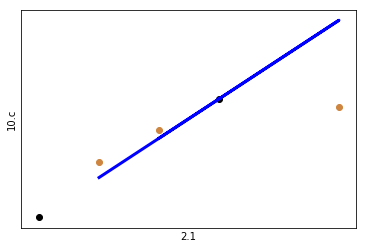

2.1 10.c
MAE: 0.46667
RMSE: 0.64807
R2: 0.000
Coefficient 2.5000000000000018
--------------------------




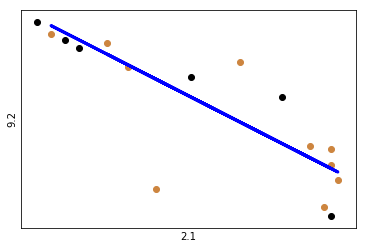

2.1 9.2
MAE: 0.18532
RMSE: 0.28641
R2: 0.530
Coefficient -0.23983169705469823
--------------------------


2.1 9.c
MAE: 5.11595
RMSE: 6.43553
R2: 0.800
Coefficient -7.805944546337253
--------------------------


2.1 15.1
MAE: 1.55720
RMSE: 2.05813
R2: 0.716
Coefficient -1.8009278239292261
--------------------------


9.4 2.1
MAE: 0.49067
RMSE: 0.57139
R2: 0.855
Coefficient -4.886292968707285e-10
--------------------------


9.2 4.2
MAE: 5.24233
RMSE: 6.71947
R2: 0.000
Coefficient 19.30703624733474
--------------------------




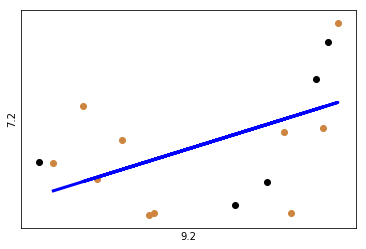

9.2 7.2
MAE: 0.33825
RMSE: 0.40478
R2: 0.089
Coefficient 0.5700751747483207
--------------------------


9.2 6.1
MAE: 2.59804
RMSE: 3.72607
R2: 0.559
Coefficient 10.247661029147181
--------------------------


9.2 6.2
MAE: 1.24490
RMSE: 1.80432
R2: 0.586
Coefficient -6.457628643396909
--------------------------




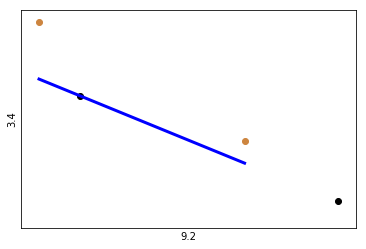

9.2 3.4
MAE: 0.03270
RMSE: 0.03578
R2: nan
Coefficient -0.10602409638554224
--------------------------




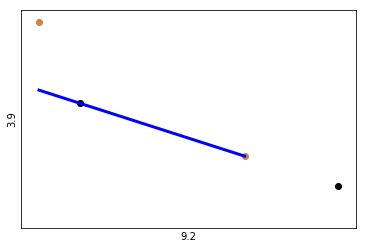

9.2 3.9
MAE: 0.01469
RMSE: 0.02076
R2: nan
Coefficient -0.04337349397590361
--------------------------




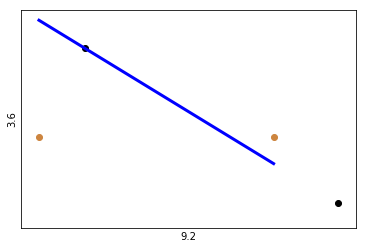

9.2 3.6
MAE: 0.06507
RMSE: 0.07668
R2: nan
Coefficient -0.19718309859154923
--------------------------


9.2 16.a
MAE: 4.16667
RMSE: 5.55488
R2: 0.370
Coefficient 19.99999999999972
--------------------------


9.2 7.1
MAE: 1.26833
RMSE: 1.35158
R2: nan
Coefficient 9.26666666666665
--------------------------


9.2 9.5
MAE: 3.82273
RMSE: 6.10167
R2: 0.587
Coefficient 20.459194619070672
--------------------------


9.2 14.5
MAE: 3.52200
RMSE: 4.16030
R2: 0.000
Coefficient 16.39999999999978
--------------------------


9.2 17.8
MAE: 4.78629
RMSE: 6.67991
R2: 0.595
Coefficient 24.1953940266283
--------------------------




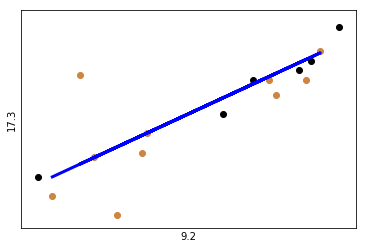

9.2 17.3
MAE: 0.05008
RMSE: 0.07784
R2: 0.494
Coefficient 0.22112270600935605
--------------------------


9.2 3.1
MAE: 2.28494
RMSE: 2.96362
R2: nan
Coefficient -8.674698795180719
--------------------------




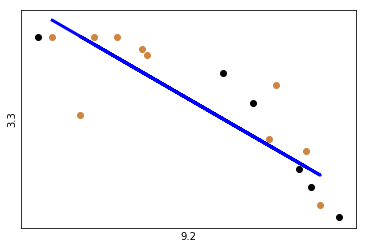

9.2 3.3
MAE: 0.47325
RMSE: 0.60749
R2: 0.576
Coefficient -2.2247211227060113
--------------------------


9.2 8.1
MAE: 1.33374
RMSE: 1.77658
R2: 0.000
Coefficient 0.129003238575026
--------------------------




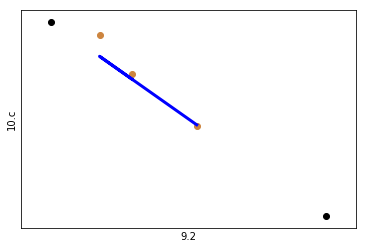

9.2 10.c
MAE: 0.07059
RMSE: 0.09808
R2: 0.883
Coefficient -8.82352941176471
--------------------------


9.2 9.c
MAE: 6.89545
RMSE: 9.99432
R2: 0.518
Coefficient 31.326286433969074
--------------------------


9.2 15.1
MAE: 1.55047
RMSE: 2.46216
R2: 0.600
Coefficient 7.004226474202307
--------------------------


9.4 9.2
MAE: 0.13987
RMSE: 0.23226
R2: 0.691
Coefficient 1.402794034611353e-10
--------------------------


9.c 4.2
MAE: 3.58122
RMSE: 4.74256
R2: 0.000
Coefficient 0.45967038429318446
--------------------------




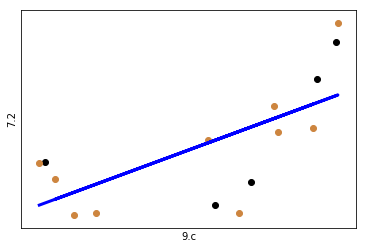

9.c 7.2
MAE: 0.24034
RMSE: 0.30171
R2: 0.494
Coefficient 0.02078693256221196
--------------------------


9.c 6.1
MAE: 2.18015
RMSE: 3.24094
R2: 0.666
Coefficient 0.3293396872396318
--------------------------


9.c 6.2
MAE: 1.31774
RMSE: 1.75363
R2: 0.609
Coefficient -0.2082308200189885
--------------------------




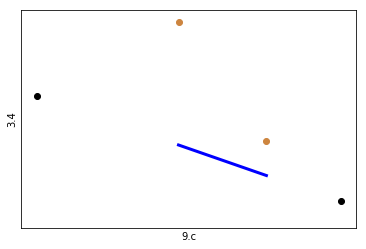

9.c 3.4
MAE: 0.06529
RMSE: 0.07494
R2: nan
Coefficient -0.002755165936130247
--------------------------




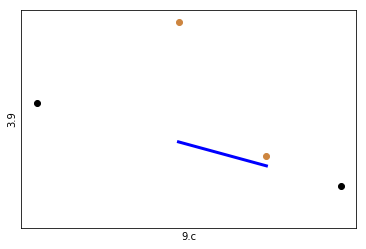

9.c 3.9
MAE: 0.02801
RMSE: 0.03675
R2: nan
Coefficient -0.0011271133375078274
--------------------------




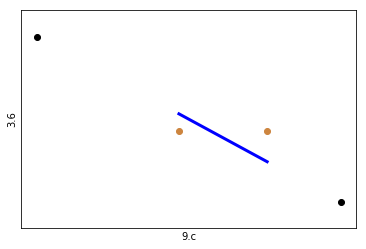

9.c 3.6
MAE: 0.02029
RMSE: 0.02112
R2: nan
Coefficient -0.004396984924623117
--------------------------


9.c 16.a
MAE: 7.99590
RMSE: 10.79463
R2: nan
Coefficient 0.23794614902943026
--------------------------


9.c 7.1
MAE: 3.64106
RMSE: 4.43154
R2: nan
Coefficient 0.2164434755527874
--------------------------


9.c 9.5
MAE: 3.45523
RMSE: 5.42838
R2: 0.673
Coefficient 0.6546255365835474
--------------------------


9.c 14.5
MAE: 3.83006
RMSE: 4.13379
R2: nan
Coefficient 0.2827175954915466
--------------------------


9.c 17.8
MAE: 5.12404
RMSE: 6.59333
R2: 0.605
Coefficient 0.7835731874291905
--------------------------




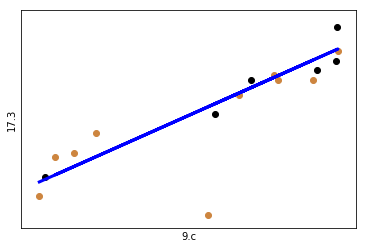

9.c 17.3
MAE: 0.04306
RMSE: 0.07605
R2: 0.517
Coefficient 0.006942870360333823
--------------------------


9.c 3.1
MAE: 4.95138
RMSE: 6.18691
R2: nan
Coefficient -0.22542266750156545
--------------------------




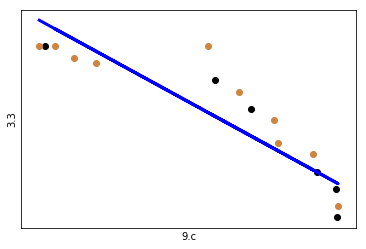

9.c 3.3
MAE: 0.44112
RMSE: 0.52286
R2: 0.686
Coefficient -0.07229761093257901
--------------------------


9.c 8.1
MAE: 1.34232
RMSE: 1.79463
R2: 0.000
Coefficient 0.0015360010994210254
--------------------------




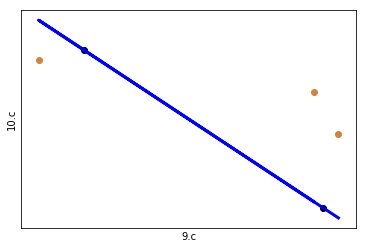

9.c 10.c
MAE: 0.74103
RMSE: 0.78947
R2: 0.000
Coefficient -0.5769230769230781
--------------------------


9.c 15.1
MAE: 1.56451
RMSE: 2.64330
R2: 0.531
Coefficient 0.23290574568597977
--------------------------


9.4 9.c
MAE: 5.68008
RMSE: 8.80579
R2: 0.626
Coefficient 4.610270020263794e-09
--------------------------


15.1 4.2
MAE: 2.45749
RMSE: 3.24521
R2: 0.000
Coefficient 1.9488598792356795
--------------------------




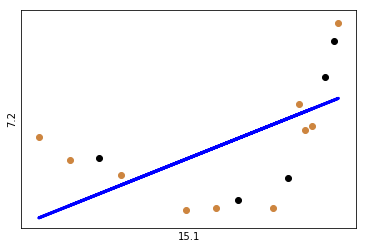

15.1 7.2
MAE: 0.34723
RMSE: 0.40883
R2: 0.070
Coefficient 0.08129204102241334
--------------------------


15.1 6.1
MAE: 1.05987
RMSE: 1.22626
R2: 0.952
Coefficient 1.4131643456312002
--------------------------


15.1 6.2
MAE: 1.11084
RMSE: 1.19549
R2: 0.818
Coefficient -0.8741309211766867
--------------------------




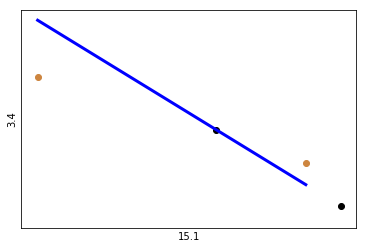

15.1 3.4
MAE: 0.04541
RMSE: 0.04962
R2: nan
Coefficient -0.018924731182795723
--------------------------




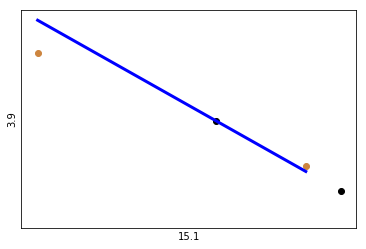

15.1 3.9
MAE: 0.00983
RMSE: 0.01200
R2: nan
Coefficient -0.00774193548387097
--------------------------




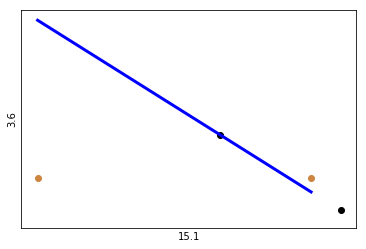

15.1 3.6
MAE: 0.15849
RMSE: 0.20665
R2: nan
Coefficient -0.03160270880361177
--------------------------


15.1 16.a
MAE: 10.33333
RMSE: 12.48012
R2: 0.000
Coefficient 0.0
--------------------------


15.1 7.1
MAE: 4.03557
RMSE: 5.08584
R2: nan
Coefficient 1.5075921908893715
--------------------------


15.1 9.5
MAE: 2.88052
RMSE: 3.15025
R2: 0.890
Coefficient 2.749746130660022
--------------------------


15.1 14.5
MAE: 8.31333
RMSE: 8.67175
R2: 0.000
Coefficient 0.0
--------------------------


15.1 17.8
MAE: 4.57561
RMSE: 4.96867
R2: 0.776
Coefficient 3.281093035129253
--------------------------




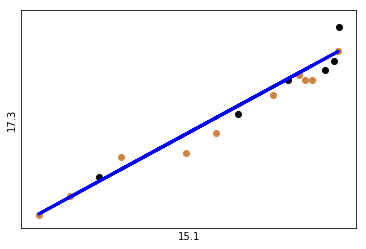

15.1 17.3
MAE: 0.01738
RMSE: 0.02184
R2: 0.960
Coefficient 0.029800375144318075
--------------------------


15.1 3.1
MAE: 3.01516
RMSE: 3.63376
R2: nan
Coefficient -1.548387096774194
--------------------------




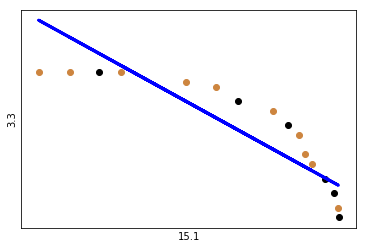

15.1 3.3
MAE: 0.52168
RMSE: 0.59541
R2: 0.593
Coefficient -0.30206174994569096
--------------------------


15.1 8.1
MAE: 1.33323
RMSE: 1.78135
R2: 0.000
Coefficient -0.006275010999601889
--------------------------




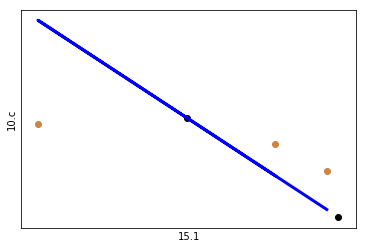

15.1 10.c
MAE: 0.87862
RMSE: 1.00705
R2: 0.000
Coefficient -2.8301886792453153
--------------------------


9.4 15.1
MAE: 0.85686
RMSE: 1.03339
R2: 0.928
Coefficient 1.0743549115940195e-09
--------------------------


9.4 4.2
MAE: 1.42393
RMSE: 1.78328
R2: 0.687
Coefficient 1.7219216738487998e-09
--------------------------


9.4 7.2
MAE: 0.34063
RMSE: 0.37685
R2: 0.210
Coefficient 1.0985963075886355e-10
--------------------------


9.4 6.1
MAE: 1.20544
RMSE: 1.46533
R2: 0.932
Coefficient 1.5783330596604616e-09
--------------------------


9.4 6.2
MAE: 0.44965
RMSE: 0.54288
R2: 0.963
Coefficient -8.829502977821912e-10
--------------------------


9.4 3.6
MAE: 0.10044
RMSE: 0.13263
R2: nan
Coefficient -2.7496106354939404e-11
--------------------------


9.4 7.1
MAE: 1.22636
RMSE: 1.51975
R2: nan
Coefficient 1.3006943274755302e-09
--------------------------


9.4 9.5
MAE: 1.44397
RMSE: 1.65939
R2: 0.969
Coefficient 3.099200441428007e-09
--------------------------


9.4 17.8
MAE: 1.88643
R

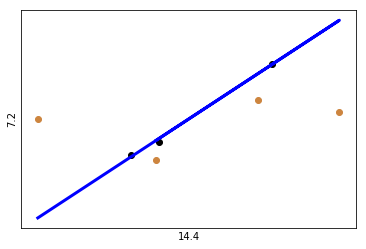

14.4 7.2
MAE: 0.79911
RMSE: 0.93748
R2: 0.000
Coefficient 0.18885281385281408
--------------------------


14.4 6.1
MAE: 3.63884
RMSE: 4.26371
R2: 0.511
Coefficient 0.7711038961038954
--------------------------


14.4 6.2
MAE: 2.25195
RMSE: 2.53391
R2: 0.104
Coefficient -0.7132034632034628
--------------------------


14.4 9.5
MAE: 7.82801
RMSE: 8.38721
R2: 0.261
Coefficient 2.2745670995670997
--------------------------


14.4 17.8
MAE: 8.26737
RMSE: 9.69319
R2: 0.015
Coefficient 2.89177489177489
--------------------------




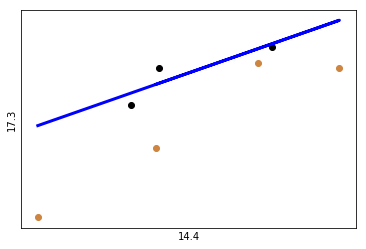

14.4 17.3
MAE: 0.10214
RMSE: 0.11481
R2: 0.073
Coefficient 0.01406926406926406
--------------------------




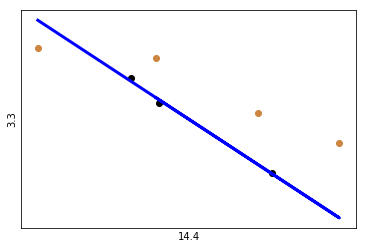

14.4 3.3
MAE: 0.97484
RMSE: 1.03541
R2: 0.000
Coefficient -0.28138528138528157
--------------------------


14.4 8.1
MAE: 1.83909
RMSE: 2.27947
R2: 0.190
Coefficient -0.13528138528138522
--------------------------


14.4 15.4
MAE: 2.81170
RMSE: 2.86120
R2: 0.322
Coefficient 0.6617965367965364
--------------------------


14.4 2.1
MAE: 1.61568
RMSE: 1.71193
R2: 0.476
Coefficient -0.5477911893438235
--------------------------




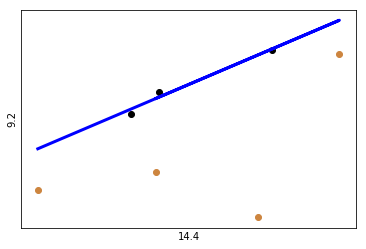

14.4 9.2
MAE: 0.46524
RMSE: 0.55680
R2: 0.000
Coefficient 0.05465367965367972
--------------------------


14.4 9.c
MAE: 12.10073
RMSE: 13.52010
R2: 0.000
Coefficient 2.3495670995671003
--------------------------


14.4 15.1
MAE: 3.17385
RMSE: 3.63093
R2: 0.228
Coefficient 0.4821428571428563
--------------------------


8.4 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
Coefficient 3.666666666666673
--------------------------


8.4 8.2
MAE: 1.32384
RMSE: 1.65040
R2: 0.000
Coefficient 0.9172585669781937
--------------------------




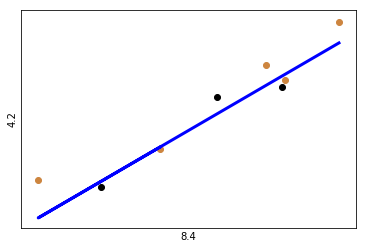

8.4 4.2
MAE: 0.41259
RMSE: 0.51328
R2: 0.858
Coefficient 2.470487215367005
--------------------------




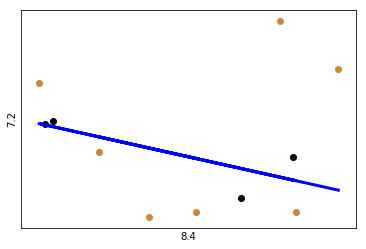

8.4 7.2
MAE: 0.29162
RMSE: 0.35259
R2: 0.000
Coefficient -0.13333333333333353
--------------------------




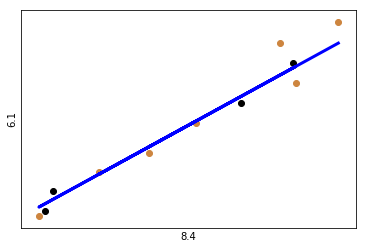

8.4 6.1
MAE: 0.94574
RMSE: 1.23218
R2: 0.937
Coefficient 5.901682242990654
--------------------------




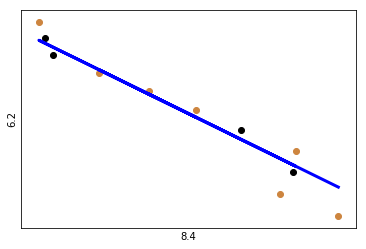

8.4 6.2
MAE: 0.50819
RMSE: 0.62736
R2: 0.904
Coefficient -2.232834890965733
--------------------------


8.4 9.5
MAE: 1.72828
RMSE: 2.04544
R2: 0.922
Coefficient 8.490554517133955
--------------------------


8.4 17.8
MAE: 2.10170
RMSE: 2.72705
R2: 0.859
Coefficient 7.3968224299065435
--------------------------




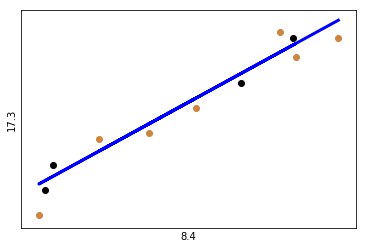

8.4 17.3
MAE: 0.02570
RMSE: 0.02814
R2: 0.915
Coefficient 0.1233021806853583
--------------------------




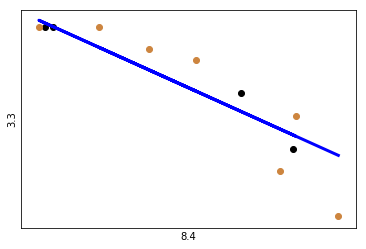

8.4 3.3
MAE: 0.25943
RMSE: 0.29880
R2: 0.769
Coefficient -0.5775700934579425
--------------------------


8.4 8.1
MAE: 1.82093
RMSE: 2.19188
R2: 0.000
Coefficient 0.2876012461059194
--------------------------




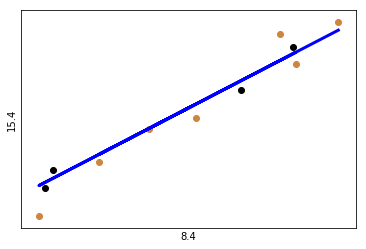

8.4 15.4
MAE: 0.59433
RMSE: 0.72947
R2: 0.931
Coefficient 3.138193146417447
--------------------------




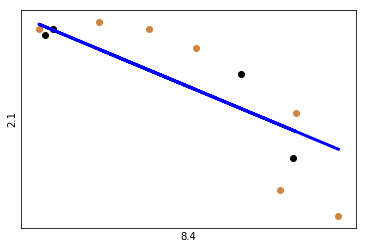

8.4 2.1
MAE: 0.58667
RMSE: 0.67395
R2: 0.670
Coefficient -0.9221183800623053
--------------------------




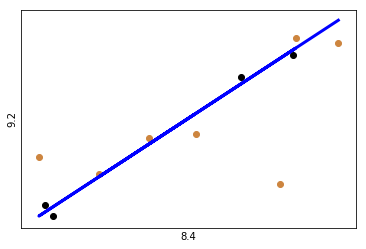

8.4 9.2
MAE: 0.20548
RMSE: 0.31303
R2: 0.052
Coefficient 0.5396261682242991
--------------------------


8.4 9.c
MAE: 7.58750
RMSE: 10.21922
R2: 0.264
Coefficient 16.44735202492212
--------------------------




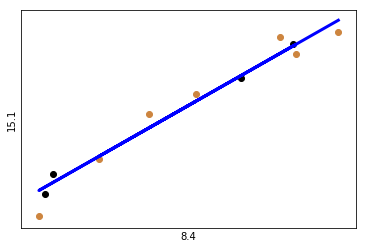

8.4 15.1
MAE: 0.68818
RMSE: 0.77889
R2: 0.949
Coefficient 4.436137071651092
--------------------------


8.2 4.2
MAE: 3.58052
RMSE: 4.39334
R2: 0.000
Coefficient -2.039870178073564
--------------------------




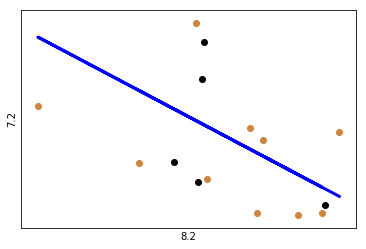

8.2 7.2
MAE: 0.38779
RMSE: 0.42975
R2: 0.000
Coefficient -0.24915747890907525
--------------------------


8.2 6.1
MAE: 5.18259
RMSE: 6.17745
R2: 0.000
Coefficient -0.2954047565950865
--------------------------


8.2 6.2
MAE: 3.02683
RMSE: 3.47316
R2: 0.000
Coefficient 0.8511497947029425
--------------------------




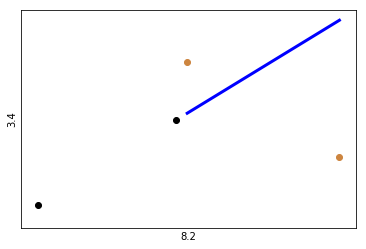

8.2 3.4
MAE: 0.09790
RMSE: 0.10737
R2: nan
Coefficient 0.08000000000000007
--------------------------




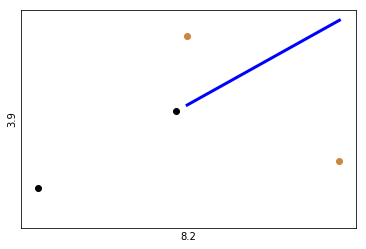

8.2 3.9
MAE: 0.04880
RMSE: 0.05159
R2: nan
Coefficient 0.03272727272727273
--------------------------




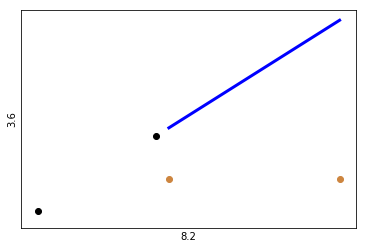

8.2 3.6
MAE: 0.19583
RMSE: 0.22027
R2: nan
Coefficient 0.1666666666666668
--------------------------


8.2 16.a
MAE: 21.85897
RMSE: 22.44388
R2: 0.000
Coefficient 7.692307692307684
--------------------------


8.2 7.1
MAE: 7.85979
RMSE: 9.63024
R2: nan
Coefficient -7.164948453608252
--------------------------


8.2 9.5
MAE: 8.68879
RMSE: 10.26816
R2: 0.000
Coefficient -0.8582728875597008
--------------------------


8.2 14.5
MAE: 17.76436
RMSE: 17.82679
R2: 0.000
Coefficient 6.307692307692304
--------------------------


8.2 17.8
MAE: 11.74453
RMSE: 13.40089
R2: 0.000
Coefficient -4.091144022772886
--------------------------




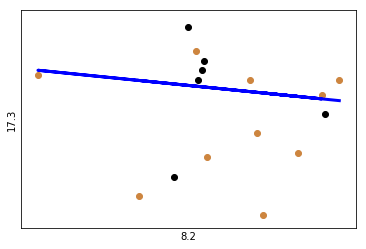

8.2 17.3
MAE: 0.09967
RMSE: 0.13077
R2: 0.000
Coefficient -0.013144258897299014
--------------------------


8.2 3.1
MAE: 8.71000
RMSE: 9.58420
R2: nan
Coefficient 6.545454545454544
--------------------------


8.2 3.3
MAE: 1.08118
RMSE: 1.19467
R2: 0.000
Coefficient 0.3801603022392471
--------------------------




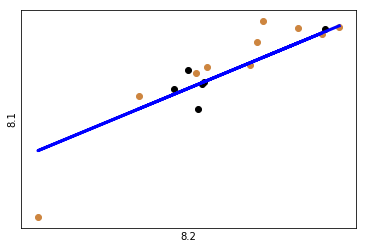

8.2 8.1
MAE: 0.56727
RMSE: 0.82698
R2: 0.779
Coefficient 0.8365494352691157
--------------------------


8.2 10.c
MAE: 1.93333
RMSE: 2.94081
R2: 0.000
Coefficient 6.521739130434782
--------------------------


8.2 15.4
MAE: 3.21827
RMSE: 3.85630
R2: 0.000
Coefficient -0.643368866998467
--------------------------


8.2 2.1
MAE: 1.69444
RMSE: 1.86022
R2: 0.000
Coefficient 0.6712492293161573
--------------------------




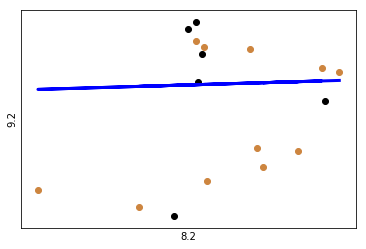

8.2 9.2
MAE: 0.42737
RMSE: 0.49368
R2: 0.000
Coefficient 0.013105550484784536
--------------------------


8.2 9.c
MAE: 13.24578
RMSE: 16.38491
R2: 0.000
Coefficient 0.23191352599335838
--------------------------


8.2 15.1
MAE: 3.27579
RMSE: 4.24261
R2: 0.000
Coefficient -0.10216646287908636
--------------------------


8.2 14.4
MAE: 4.20861
RMSE: 5.07446
R2: 0.077
Coefficient -1.9044337002366019
--------------------------




In [27]:
keptPairs = list()
processedPairs = list()
notPercentTargets = ['12.2', '9.4', '8.4', '17.2', '17.19']   # work on this
highValueTargets = ['9.4', '17.19']
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}

n_connections = 0

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    if ((targety in notPercentTargets and not targetx in notPercentTargets) or targety in highValueTargets):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        
                        coef = linreg.coef_[0][0]
                        
                        # filter out independant variables (coefficient close to 0, coefficient > 100)
                        if (0.001 < np.abs(coef) < 100):
                        
                            if targety in notPercentTargets:

                                if 0<=mae<0.1: # 1 percent tolerance (converted to tonnes)
                                    #print('MAE', targetx, targety, mae)
                                    keptPairs.extend([tuple((targetx, targety))])

                                    if coef > 0: edge_color = 'g'#edgecolor.append('g')
                                    else: edge_color = 'r'
                                    
                                    edgecolor.append(edge_color)
                                    pairsAndRel[targetx, targety] = edge_color

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])


                            else:
                                if 1 > mae > 0: # tolerate 1 percent error
                                    keptPairs.extend([tuple((targetx, targety))])
                                    
                                    if coef > 0: edge_color = 'g'#edgecolor.append('g')
                                    else: edge_color = 'r'
                                    
                                    edgecolor.append(edge_color)
                                    pairsAndRel[targetx, targety] = edge_color

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])
                        
                        else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('Coefficient', coef)
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [28]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  135


In [29]:
print(keptPairs)

[('4.2', '7.2'), ('4.2', '6.2'), ('7.2', '3.6'), ('6.1', '3.4'), ('6.1', '3.9'), ('6.1', '3.6'), ('6.2', '3.4'), ('6.2', '3.9'), ('6.2', '3.6'), ('3.4', '3.9'), ('12.2', '17.3'), ('12.2', '3.3'), ('7.1', '7.2'), ('7.1', '6.2'), ('12.2', '15.4'), ('12.2', '2.1'), ('12.2', '9.2'), ('12.2', '15.1'), ('12.2', '4.2'), ('12.2', '7.2'), ('12.2', '6.1'), ('12.2', '6.2'), ('12.2', '8.4'), ('9.5', '7.2'), ('9.5', '6.2'), ('9.5', '3.6'), ('9.5', '7.1'), ('9.5', '17.3'), ('9.5', '3.3'), ('9.5', '10.c'), ('14.5', '3.4'), ('14.5', '3.9'), ('14.5', '17.3'), ('14.5', '3.3'), ('14.5', '8.1'), ('17.8', '4.2'), ('17.8', '7.2'), ('17.8', '6.2'), ('17.8', '3.4'), ('17.8', '3.9'), ('17.8', '3.6'), ('17.8', '7.1'), ('17.8', '17.3'), ('17.8', '3.3'), ('17.8', '10.c'), ('17.3', '7.2'), ('17.3', '6.2'), ('17.3', '3.4'), ('17.3', '3.9'), ('17.3', '3.6'), ('17.3', '3.1'), ('17.3', '3.3'), ('17.3', '10.c'), ('3.1', '3.4'), ('3.1', '3.9'), ('3.1', '3.3'), ('3.1', '8.1'), ('3.3', '4.2'), ('3.3', '7.2'), ('3.3', '6.2

In [30]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
print(discardedPairs)

[['4.2', '6.1'], ['17.2', '4.2'], ['17.2', '7.1'], ['17.2', '12.2'], ['17.2', '9.5'], ['17.2', '14.5'], ['17.2', '17.8'], ['17.2', '17.3'], ['17.2', '3.1'], ['17.2', '3.3'], ['17.2', '8.1'], ['17.2', '10.c'], ['17.19', '17.2'], ['17.19', '15.4'], ['17.19', '2.1'], ['17.19', '9.2'], ['17.19', '9.c'], ['17.19', '15.1'], ['9.4', '17.19'], ['9.4', '14.4'], ['9.4', '8.4'], ['9.4', '8.2'], ['7.2', '6.1'], ['7.2', '6.2'], ['17.2', '7.2'], ['17.2', '15.4'], ['17.2', '2.1'], ['17.2', '9.2'], ['17.2', '9.c'], ['17.2', '15.1'], ['9.4', '17.2'], ['6.1', '6.2'], ['6.1', '16.a'], ['17.2', '6.1'], ['17.2', '14.4'], ['17.2', '8.4'], ['17.2', '8.2'], ['6.2', '16.a'], ['17.2', '6.2'], ['3.4', '16.a'], ['17.2', '3.4'], ['3.9', '16.a'], ['17.2', '3.9'], ['17.2', '3.6'], ['17.2', '16.a'], ['12.2', '9.5'], ['12.2', '17.8'], ['12.2', '8.1'], ['17.19', '12.2'], ['17.19', '14.4'], ['17.19', '8.4'], ['17.19', '8.2'], ['7.1', '6.1'], ['12.2', '9.c'], ['9.4', '12.2'], ['12.2', '14.4'], ['12.2', '8.2'], ['9.5', '4

## 2. Graphical Models

In [31]:
import networkx as nx

In [32]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

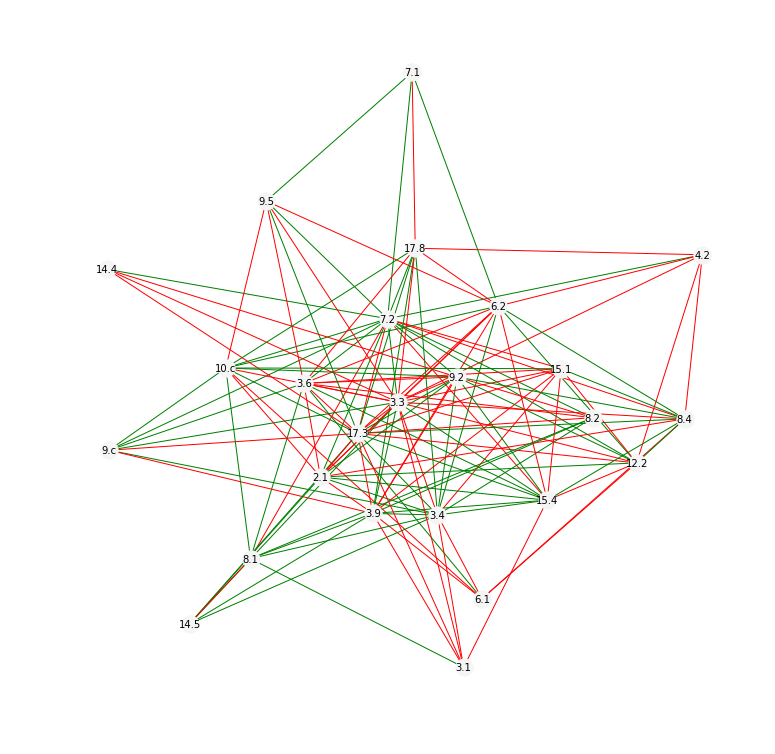

In [33]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(10,10)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph.

In [34]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
overlay.show()
overlay.save("final.png")
#imshow(np.asarray(overlay), aspect='equal')

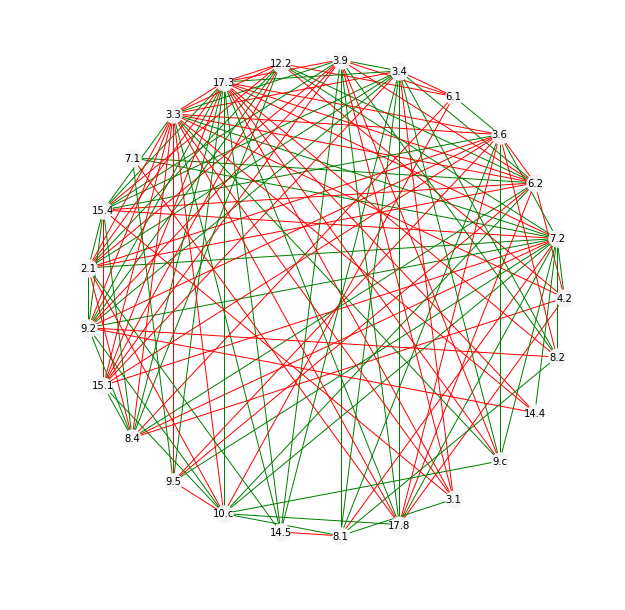

In [35]:
pos = nx.circular_layout(G1) # choose layout
# default

plt.figure(1,figsize=(8,8)) 
nx.draw(G1,pos, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.show()

In [36]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['4.2', '3.3', '7.2', '12.2', '8.4'],
 ['4.2', '3.3', '7.2', '17.8'],
 ['4.2', '3.3', '6.2', '12.2', '8.4'],
 ['4.2', '3.3', '6.2', '17.8'],
 ['8.1', '10.c', '7.2'],
 ['8.1', '7.2', '3.6', '8.2'],
 ['8.1', '3.4', '3.9', '3.1'],
 ['8.1', '3.4', '3.9', '14.5'],
 ['8.1', '3.4', '3.9', '8.2'],
 ['6.1', '3.4', '3.9'],
 ['6.1', '3.6'],
 ['6.1', '12.2', '8.4'],
 ['6.1', '10.c'],
 ['17.3', '8.2', '9.2', '3.9', '3.4'],
 ['17.3', '8.2', '9.2', '7.2', '3.6'],
 ['17.3', '3.3', '7.2', '9.2', '2.1', '15.4', '3.6'],
 ['17.3', '3.3', '7.2', '9.2', '2.1', '15.4', '8.4', '12.2'],
 ['17.3', '3.3', '7.2', '9.2', '2.1', '10.c'],
 ['17.3', '3.3', '7.2', '9.2', '14.4'],
 ['17.3', '3.3', '7.2', '9.c', '3.6'],
 ['17.3', '3.3', '7.2', '9.c', '10.c'],
 ['17.3', '3.3', '7.2', '15.1', '15.4', '12.2', '8.4'],
 ['17.3', '3.3', '7.2', '15.1', '15.4', '3.6'],
 ['17.3', '3.3', '7.2', '15.1', '10.c'],
 ['17.3', '3.3', '7.2', '9.5', '3.6'],
 ['17.3', '3.3', '7.2', '9.5', '10.c'],
 ['17.3', '3.3', '7.2', '17.8', '3.6'],


In [37]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [38]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [39]:
cliqueGraph = complete_graph_from_list(max_clique)

In [40]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [41]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

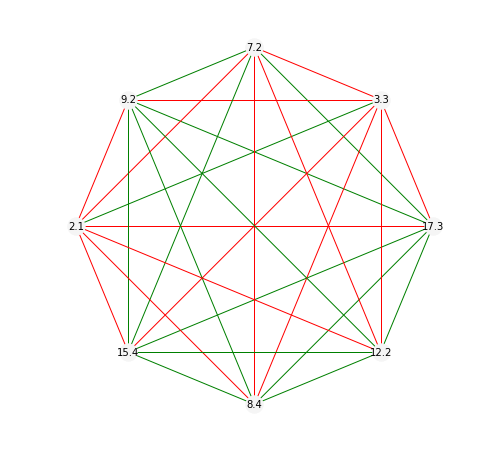

In [42]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

## 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them

In [43]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=43


In [44]:
# What is observed and what is missing?

#perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

#perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

NameError: name 'perm1' is not defined

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}

Note that we want to make the missing observation dependent on one previous observation. This is equivalent to define an autoregressive model of order 1.

In [ ]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients. 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}
model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    
    for(t in 2:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-1):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-1):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

# what to do next: define huge for loop over all what follows from here?

In [ ]:
# prepare data for STAN model
data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

In [ ]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

In [ ]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
# what do we actually want to show? sigma and tau are performance measurements. Interesting for us, but we want to see more
fit.plot(["tau","sigma","lp__"]) # take vars from temporal model
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat1 = samples["y_mis1"].mean(axis=0)
y_std1 = samples["y_mis1"].std(axis=0)

y_hat2 = samples["y_mis2"].mean(axis=0)
y_std2 = samples["y_mis2"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
def compute_error2(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
# insert def compute_error if deleted above
corr, mae, rae, rmse, r2 = compute_error2(y_mis1, y_hat) #for missing variables
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))